In [1]:
import pickle
import vector
import numpy as np
import awkward as ak
from tqdm import tqdm
from scipy.stats import chi2
import matplotlib.pyplot as plt

In [2]:
pt_cut = 1.0 #GeV
eta_cut = 4.0
file="WS_Preprocessed_ttbar_semiLep_mu200_minJetpT25/data_combined.pkl"

In [3]:
def load_and_preprocess(file):
    with open(file,"rb") as f:
        #print(f.keys())
        data = pickle.load(f)
        trks = data["trks"]
    trk_pt = trks[:,:,0]
    trk_eta = trks[:,:,1]
    trk_phi = trks[:,:,2]
    trk_q = trks[:,:,3]
    trk_ID = trks[:,:,-2]
    trk_label = trks[:,:,-1]
    trk_vect = vector.Array(ak.zip({"pt": trk_pt,"eta": trk_eta,"phi": trk_phi,"m": ak.zeros_like(trk_pt)}))
    mask = (trk_pt>pt_cut) & (np.abs(trk_eta)<eta_cut) & (trk_q!=0)
    trk_pass = trk_vect[mask]
    isHS=trk_label[mask]==-1
    IDs = trk_ID[mask]
    return trk_pass, isHS, IDs

In [4]:
def do_PUPPI(trks, labels):
    trk_pair_1, trk_pair_2 = ak.unzip(ak.cartesian([trks,trks], axis=1, nested=True))
    distances = trk_pair_1.deltaR(trk_pair_2)+1e-8
    delta_R_mask = ((distances<0.3) & (distances>0.02))*1
    epsilon = (trk_pair_2.pt / distances)
    alpha_i = np.log(ak.sum(epsilon*delta_R_mask, axis=-1)+1e-20)
    sorted_alpha = ak.sort(alpha_i[~labels])
    num = ak.num(alpha_i[~labels])//2
    median_alpha = sorted_alpha[np.arange(len(num)), num]
    var_alpha = np.sqrt(ak.mean(alpha_i[~labels],axis=1)**2)
    chi_squared = (((alpha_i-median_alpha)>0)*1)*(alpha_i - median_alpha)**2/var_alpha**2
    PUPPI_weights = ak.unflatten(chi2.cdf(ak.flatten(chi_squared),1), ak.num(chi_squared))
    return PUPPI_weights, alpha_i

In [5]:
trks, labels, IDs = load_and_preprocess(file)

In [6]:
num_events = len(trks)
batch=100
batches = np.arange(0, num_events+1, batch)

In [7]:
PUPPI_weights = []
alpha_i = []
for i in tqdm(range(len(batches)-1)):
    event_start = batches[i]
    event_end = batches[i+1]
    weights, alpha = do_PUPPI(trks[event_start:event_end], labels[event_start:event_end])
    PUPPI_weights.append(weights)
    alpha_i.append(alpha)
PUPPI_weights = ak.concatenate(PUPPI_weights,axis=0)
alpha_i = ak.concatenate(alpha_i,axis=0)

100%|██████████| 100/100 [17:01<00:00, 10.22s/it]


In [8]:
isHS=labels
isPU=~isHS

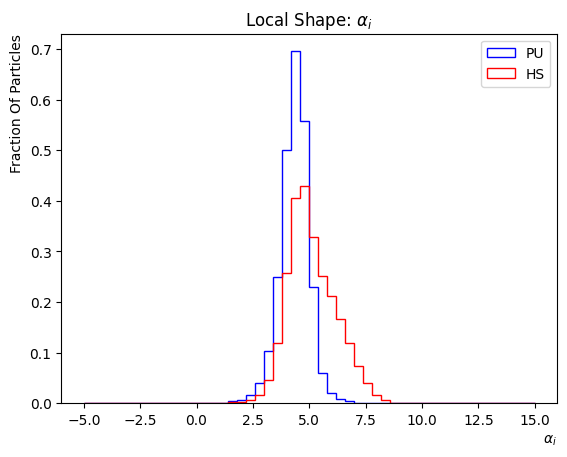

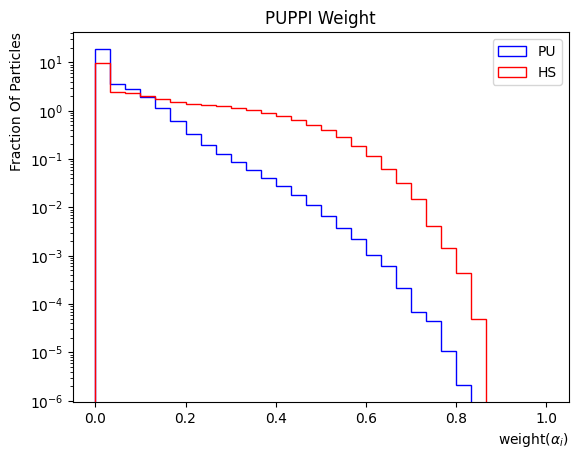

In [9]:
plt.title(r'Local Shape: $\alpha_i$')
plt.hist(ak.flatten(alpha_i[isPU]),bins=50,range=(-5,15),density=True,histtype='step',label='PU',color='b')
plt.hist(ak.flatten(alpha_i[isHS]),bins=50,range=(-5,15),density=True,histtype='step',label='HS',color='r')
plt.xlabel(r'$\alpha_i$',loc='right')
plt.ylabel("Fraction Of Particles",loc='top')
plt.legend()
plt.show()

plt.title("PUPPI Weight")
plt.hist(ak.flatten(PUPPI_weights[isPU]),bins=30,range=(0,1),density=True,histtype='step',label='PU',color='b')
plt.hist(ak.flatten(PUPPI_weights[isHS]),bins=30,range=(0,1),density=True,histtype='step',label='HS',color='r')
plt.xlabel(r'weight($\alpha_i$)',loc='right')
plt.ylabel("Fraction Of Particles",loc='top')
plt.yscale('log')
plt.legend()
plt.show()

In [10]:
with open(file,"rb") as f:
    data = pickle.load(f)
    jets = data["jets"]
    jet_trk_IDs = data["jet_trk_IDs"]
    trk_full = data["trks"]

In [11]:
mask = (jets[:,:,4]>0.2) & (jets[:,:,5]>0.1)

In [12]:
jets_pass = jets[mask]
IDs_pass = jet_trk_IDs[mask]

In [13]:
jet_true = []
jet_pred = []

# Loop over event
for event in tqdm(range(100)):
    # Loop over jets in the event
    num_jets = len(jets_pass[event])
    for jet in range(num_jets):

        # Init true and pred trk list
        trk_true_vec_list=[]
        trk_pred_vec_list=[]

        # Loop over trk IDs within jet
        for trk_ID in IDs_pass[event][jet]:
            # Try to find ID in trk array
            arg = np.ravel(np.argwhere(IDs[event]==trk_ID))
            if len(arg)==0:
                continue

            # Store trk with true weight
            true_weight = labels[event,arg]*1
            trk_true_vec = trks[event,arg]*true_weight
            trk_true_vec_list.append(trk_true_vec[0])

            # Store trk with PUPPI weight
            PUPPI_weight = PUPPI_weights[event,arg]
            trk_pred_vec = trks[event,arg]*PUPPI_weight
            trk_pred_vec_list.append(trk_pred_vec[0])

        # Calculate reconstructed jet
        jet_true_reco = np.sum(trk_true_vec_list)
        jet_pred_reco = np.sum(trk_pred_vec_list)

        # Store results
        jet_true.append(jet_true_reco)
        jet_pred.append(jet_pred_reco)

# Convert to numpy
jet_true = np.array(jet_true)
jet_pred = np.array(jet_pred)

100%|██████████| 100/100 [06:39<00:00,  3.99s/it]


In [14]:
true_mass = np.array([jet.m+1e-8 for jet in jet_true])
pred_mass = np.array([jet.m for jet in jet_pred])
mass_resolution = (pred_mass-true_mass)/true_mass

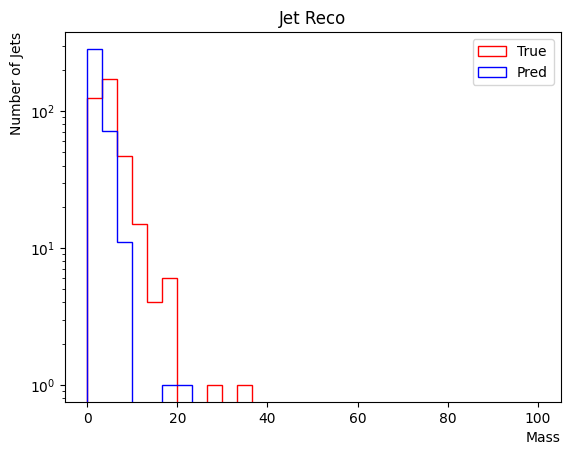

In [15]:
plt.title("Jet Reco")
plt.hist(true_mass,bins=30,range=(0,100),histtype='step',label='True',color='r')
plt.hist(pred_mass,bins=30,range=(0,100),histtype='step',label='Pred',color='b')
plt.xlabel("Mass",loc='right')
plt.ylabel("Number of Jets",loc='top')
plt.yscale('log')
plt.legend()
plt.show()

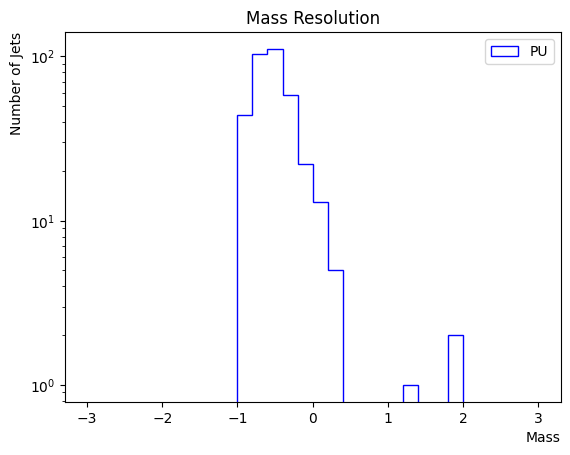

In [16]:
plt.title("Mass Resolution")
plt.hist(mass_resolution,bins=30,range=(-3,3),histtype='step',label='PU',color='b')
plt.xlabel("Mass",loc='right')
plt.ylabel("Number of Jets",loc='top')
plt.yscale('log')
plt.legend()
plt.show()

In [17]:
true_energy = np.array([jet.e+1e-8 for jet in jet_true])
pred_energy = np.array([jet.e for jet in jet_pred])
energy_resolution = (pred_energy-true_energy)/true_energy

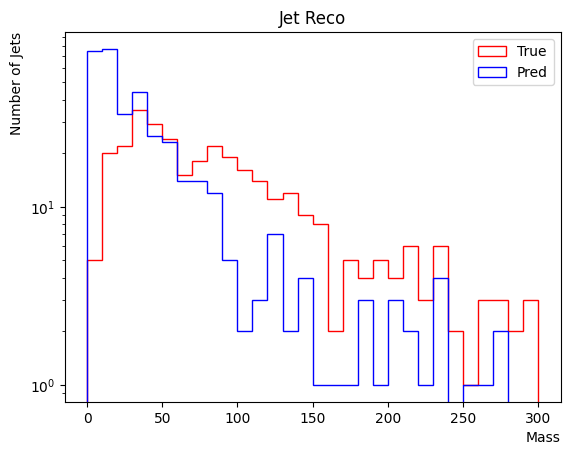

In [18]:
plt.title("Jet Reco")
plt.hist(true_energy,bins=30,range=(0,300),histtype='step',label='True',color='r')
plt.hist(pred_energy,bins=30,range=(0,300),histtype='step',label='Pred',color='b')
plt.xlabel("Mass",loc='right')
plt.ylabel("Number of Jets",loc='top')
plt.yscale('log')
plt.legend()
plt.show()

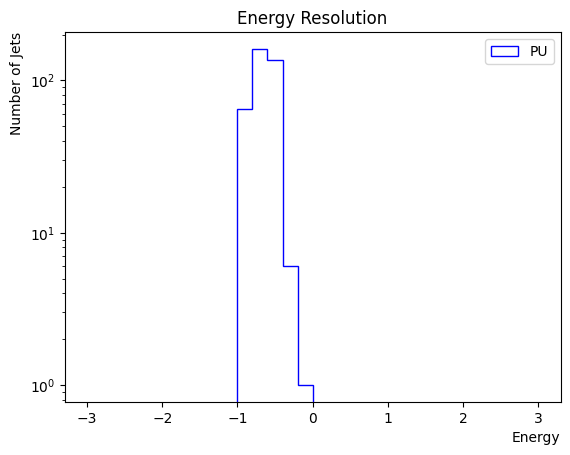

In [19]:
plt.title("Energy Resolution")
plt.hist(energy_resolution,bins=30,range=(-3,3),histtype='step',label='PU',color='b')
plt.xlabel("Energy",loc='right')
plt.ylabel("Number of Jets",loc='top')
plt.yscale('log')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import r2_score
print("Energy r2:\t", r2_score(true_energy,pred_energy))
print("Mass r2:\t", r2_score(true_mass,pred_mass))

Energy r2:	 0.3480545251802222
Mass r2:	 0.11480276420881896
